In [116]:

import pandas as pd 
import torch 
import matplotlib.pyplot as plt
import numpy as np 


#Определим сеть

In [117]:
from torch import nn
class Perceptron1(torch.nn.Module):
    def __init__(self, input_size=10, output_size=1):
        super(Perceptron1, self).__init__()
        self.fc1 = nn.Linear(input_size, 1000)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(1000, 500)
        self.act2 = nn.Sigmoid()
        self.fc3 = nn.Linear(500, 250)
        self.act3 = nn.Sigmoid()
        self.fc4 = nn.Linear(250, 125)
        self.act4 = nn.Sigmoid()
        self.fc5 = nn.Linear(125, output_size)
        self.act5 = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        return x

class Perceptron2(torch.nn.Module):
    def __init__(self, input_size=10, output_size=1):
        super(Perceptron2, self).__init__()
        self.fc1 = nn.Linear(input_size, 500)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(500, 1000)
        self.act2 = nn.Sigmoid()
        self.fc3 = nn.Linear(1000, 2000)
        self.act3 = nn.Sigmoid()
        self.fc4 = nn.Linear(2000, 1000)
        self.act4 = nn.Sigmoid()
        self.fc5 = nn.Linear(1000, 800)
        self.act5 = nn.Sigmoid()
        self.fc6 = nn.Linear(800, 200)
        self.act6 = nn.Sigmoid()
        self.fc7 = nn.Linear(200, output_size)
        self.act7 = nn.Tanh()
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        x = self.fc6(x)
        x = self.act6(x)
        x = self.fc7(x)
        x = self.act7(x)
        return x

class LSTM(nn.Module):
    def __init__(self, input_size=10, hidden_layer_size=10, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size)) 

    def forward(self, input_seq):
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size), torch.zeros(1, 1, self.hidden_layer_size))
        
        item = input_seq.view(len(input_seq), 1, -1)
        
        lstm_out, self.hidden_cell = self.lstm(item, self.hidden_cell)
        
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions.view(-1)
class LSTM1(nn.Module):
    def __init__(self, input_size=10, hidden_layer_size=10, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = Perceptron1(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size)) 

    def forward(self, input_seq):
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size), torch.zeros(1, 1, self.hidden_layer_size))
        # print("input_seq size ", input_seq.size())
        item = input_seq.view(len(input_seq), 1, -1)
        # print("item size ", item.size())
        lstm_out, self.hidden_cell = self.lstm(item, self.hidden_cell)
        # print("lstm_out size ", lstm_out.size())
        # print("hidden_cell size", self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions.view(-1)
class LSTM2(nn.Module):
    def __init__(self, input_size=10, hidden_layer_size=10, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = Perceptron2(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size)) 

    def forward(self, input_seq):
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size), torch.zeros(1, 1, self.hidden_layer_size))
        # print("input_seq size ", input_seq.size())
        item = input_seq.view(len(input_seq), 1, -1)
        # print("item size ", item.size())
        lstm_out, self.hidden_cell = self.lstm(item, self.hidden_cell)
        # print("lstm_out size ", lstm_out.size())
        # print("hidden_cell size", self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions.view(-1)

Обучение

In [118]:
import time
def generate_batch_data(device, x, y, batch_size):
    dataset = torch.utils.data.TensorDataset(x.to(device), y.to(device))
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

    for batch, [x_batch, y_batch] in enumerate(loader, 1):
        yield x_batch, y_batch, batch
def to_train(model, n_epochs, device, x_train, y_train, x_validatation, y_validatation, batch_size, loss_function, optimizer):
    train_losses = []
    validation_losses = []
    model.train()
    for epoch in range(n_epochs):
        start_time = time.time()

        train_loss = 0
        val_loss = 0
        batch = 0
        for x_batch, y_batch, batch in generate_batch_data(device, x_train, y_train, batch_size):    
            y_pred = model(x_batch)

            optimizer.zero_grad()
            
            loss = loss_function(y_pred, y_batch)
            loss.backward(retain_graph=True)
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= batch
        train_losses.append(train_loss)

        with torch.no_grad():
            for x_val_batch, y_val_batch, n in generate_batch_data(device, x_validatation, y_validatation, batch_size):
                val_loss += loss_function(model(x_val_batch), y_val_batch).item()
            val_loss /= n
            validation_losses.append(val_loss)
        elapsed = time.time() - start_time
        if True:
            print(f"Epoch {str(epoch + 1):>02}"
                    f" Train loss: {train_loss:.7f}."
                    f" Validation loss: {val_loss:.7f}."
                    f" Elapsed time: {elapsed:.2f}s.")
    plt.plot(range(len(train_losses)), train_losses, label="train_losses")
    plt.plot(range(len(validation_losses)), validation_losses, label="validation_losses")
    plt.legend(loc='upper center')
    plt.show()
    return model, train_losses, validation_losses

Сделаем предобработку

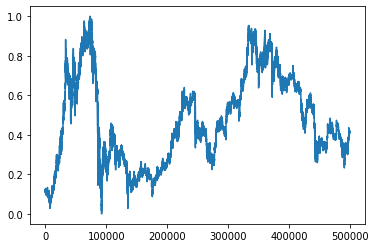

/Users/petrlarockin/Downloads/Практикум Дискретные Структуры/discrete_structures/HM1/env/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/petrlarockin/Downloads/Практикум Дискретные Структуры/discrete_structures/HM1/env/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/petrlarockin/Downloads/Практикум Дискретные Структуры/discrete_structures/HM1/env/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: U

Epoch 01 Train loss: 0.0387253. Validation loss: 0.1442227. Elapsed time: 39.12s.
Epoch 02 Train loss: 0.0289697. Validation loss: 0.0366126. Elapsed time: 37.90s.
Epoch 03 Train loss: 0.0190883. Validation loss: 0.0355696. Elapsed time: 38.38s.
Epoch 04 Train loss: 0.0161096. Validation loss: 0.0486674. Elapsed time: 38.42s.
Epoch 05 Train loss: 0.0144694. Validation loss: 0.0466069. Elapsed time: 38.54s.


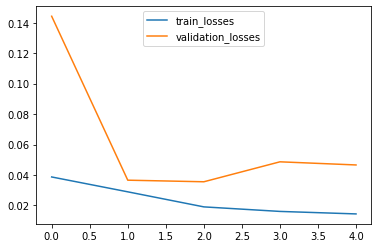

Epoch 01 Train loss: 0.0287955. Validation loss: 0.2119516. Elapsed time: 253.48s.
Epoch 02 Train loss: 0.0417134. Validation loss: 0.2118618. Elapsed time: 3947.25s.
Epoch 03 Train loss: 0.0427783. Validation loss: 0.2118493. Elapsed time: 290.47s.
Epoch 04 Train loss: 0.0441613. Validation loss: 0.2120056. Elapsed time: 279.93s.
Epoch 05 Train loss: 0.0444022. Validation loss: 0.2118133. Elapsed time: 280.07s.


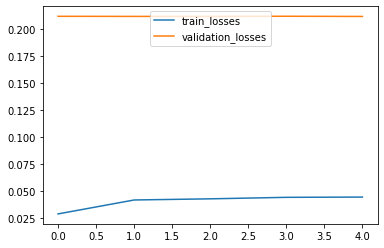

Epoch 01 Train loss: 0.0257912. Validation loss: 0.0383641. Elapsed time: 58.03s.
Epoch 02 Train loss: 0.0088881. Validation loss: 0.0148115. Elapsed time: 57.95s.
Epoch 03 Train loss: 0.0054613. Validation loss: 0.0106915. Elapsed time: 57.99s.
Epoch 04 Train loss: 0.0045316. Validation loss: 0.0111159. Elapsed time: 57.98s.
Epoch 05 Train loss: 0.0040594. Validation loss: 0.0109681. Elapsed time: 57.43s.


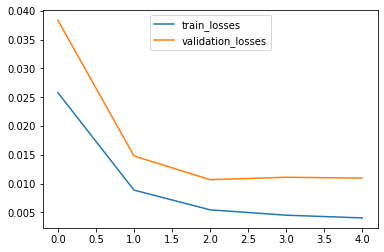

Epoch 01 Train loss: 0.0405783. Validation loss: 0.1934748. Elapsed time: 101.64s.
Epoch 02 Train loss: 0.0441535. Validation loss: 0.1205353. Elapsed time: 95.41s.
Epoch 03 Train loss: 0.0245002. Validation loss: 0.0422040. Elapsed time: 104.69s.
Epoch 04 Train loss: 0.0153256. Validation loss: 0.0485081. Elapsed time: 98.04s.
Epoch 05 Train loss: 0.0124261. Validation loss: 0.0447746. Elapsed time: 97.28s.


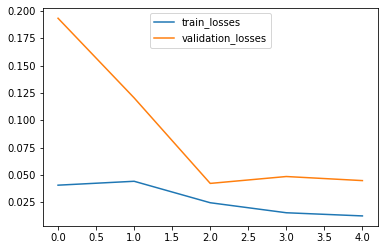

Epoch 01 Train loss: 0.0258775. Validation loss: 0.2207994. Elapsed time: 322.11s.
Epoch 02 Train loss: 0.0330174. Validation loss: 0.2132876. Elapsed time: 327.75s.
Epoch 03 Train loss: 0.0398543. Validation loss: 0.2121024. Elapsed time: 328.55s.
Epoch 04 Train loss: 0.0425962. Validation loss: 0.2119150. Elapsed time: 332.27s.
Epoch 05 Train loss: 0.0439028. Validation loss: 0.2122915. Elapsed time: 332.71s.


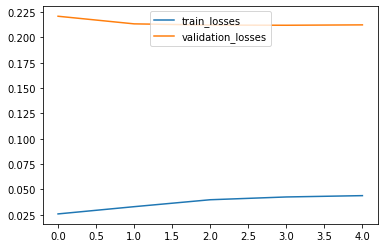

In [119]:
from sklearn.preprocessing import MinMaxScaler
time_series = list(map(float, eval(open('task1.txt', 'r').read())))
scaler = MinMaxScaler()
data = [(i, item) for i, item in enumerate(time_series)]
scaler.fit(data)
std_time_series = [ item for _, item in scaler.transform(data)]
plt.plot(std_time_series)
plt.show()

train = std_time_series[:int(len(std_time_series) * 0.8)]
valid = std_time_series[int(len(std_time_series) * 0.8): int(len(std_time_series) * 0.99)]
x_train = torch.from_numpy(np.array([train[i:i+10] for i in range(len(train) - 10)])).float()
x_validatation = torch.from_numpy(np.array([valid[i:i+10] for i in range(len(valid) - 10)])).float()
y_train = torch.FloatTensor(train[10:])
y_validatation = torch.FloatTensor(valid[10:])
models = [Perceptron1(), Perceptron2(), LSTM(10,10,1), LSTM1(10,10,1), LSTM2(10,10,1)]
done_models = []
for model in models:
    # model = LSTM(10,10,1)
    device = torch.device('cpu')
    batch_size= 100
    n_epochs= 5
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_function = torch.nn.L1Loss()
    done_model1, train_loss1, val_loss1 = to_train(model, n_epochs, device, x_train, y_train, x_validatation, y_validatation, batch_size, loss_function, optimizer)
    done_model1.eval()
    done_models.append(done_model1)


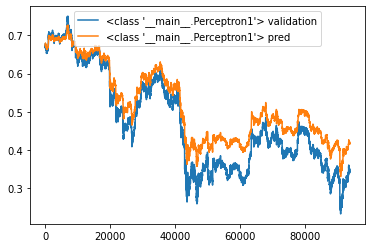

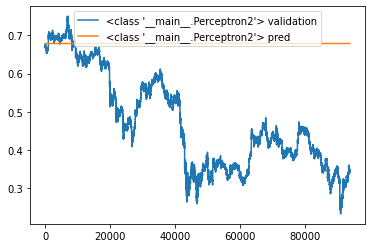

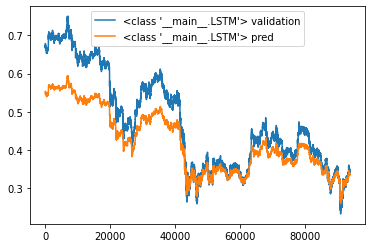

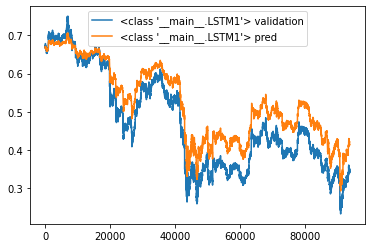

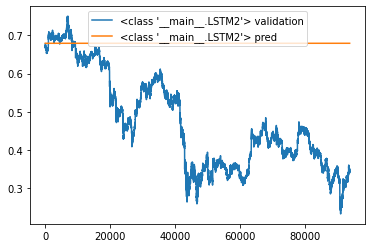

In [120]:
# print(x_validatation[0])
def show_predict(done_model):
    with torch.no_grad():
        pred_1 = list(map(lambda item: done_model(item.view(1, 1, 10)).item(), x_validatation ))
        pred_all = list(x_validatation[0])
        for i in range(len(y_validatation)):
            pred_all.append(done_model(torch.FloatTensor(pred_all[i:i+10]).view(1, 1, 10)).item())
        ratio = 0.99
        plt.plot(range(len(y_validatation[:int(len(y_validatation)*ratio)])), y_validatation[:int(len(y_validatation)*ratio)], label="{} validation".format(type(done_model)))
        plt.plot(range(len(pred_1[:int(len(pred_1)*ratio)])), pred_1[:int(len(pred_1)*ratio)], label="{} pred".format(type(done_model)))
        # plt.plot(range(len(pred_all[:int(len(pred_all)*ratio)])), pred_all[:int(len(pred_all)*ratio)], label="pred all")
        plt.legend(loc='upper center')
        plt.show()
for done_model in done_models:
    show_predict(done_model)

In [123]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff


def inverse_difference(inverted, first_value):
    original = [first_value]
    for i, item in enumerate(inverted):
        original.append(original[i] + item)
    return original

Система принятия решения

In [ ]:
from torch import nn
class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(10, 500)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(500, 1000)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(1000, 500)
        self.act3 = nn.Tanh()
        self.fc4 = nn.Linear(500, 250)
        self.act4 = nn.Tanh()
        self.fc5 = nn.Linear(250, 1)
        self.act5 = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        return x
classifier = Classifier()
device = torch.device('cpu')
batch_size= 800
n_epochs= 20
train_losses = []
validation_losses = []
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001)
loss_function = torch.nn.BCELoss()


y_train = torch.from_numpy(np.array(difference(train[10:])))
y_train[y_train > 0] = 1
y_train[y_train <= 0] = 0

y_validatation = torch.from_numpy(np.array(difference(valid[10:])))
y_validatation[y_validatation > 0] = 1
y_validatation[y_validatation <= 0] = 0

print(x_train.size())
print(y_train.size())
print(x_validatation.size())
print(y_validatation.size())

classificator, classificator_train, classificator_validation = to_train(classifier, n_epochs, device, x_train, y_train, x_validatation, y_validatation, batch_size, loss_function, optimizer)

In [ ]:
def get_recomendation(classificator, first_ten, thresh):
    first_ten = torch.tensor(first_ten)
    ans = classificator(first_ten)
    return ans >= thresh